In [6]:
import pymc3 as pm 

In [7]:
# Bayesian Binary logistic regression in 1d for iris flowers

# Code is based on
# https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb


# try:
#     import pymc3 as pm
# except ModuleNotFoundError:
#     %pip install -qq pymc3
#     import pymc3 as pm

import numpy as np

try:
    import pandas as pd
except ModuleNotFoundError:
    %pip install -qq pandas
    import pandas as pd
try:
    import theano.tensor as tt
except ModuleNotFoundError:
    %pip install -qq theano
    import theano.tensor as tt
# import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az
try:
    from sklearn.datasets import load_iris
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.datasets import load_iris
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml


In [32]:
# load data
iris = load_iris()
X = iris.data
y = iris.target

# Convert to pandas dataframe
df_iris = pd.DataFrame(data=iris.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
df_iris["species"] = pd.Series(iris.target_names[y], dtype="category")

df = df_iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df["species"]).codes
x_n = "sepal_length"
x_0 = df[x_n].values

xmean = np.mean(x_0)
x_c = x_0 - xmean

print(x_c)

[-0.371 -0.571 -0.771 -0.871 -0.471 -0.071 -0.871 -0.471 -1.071 -0.571
 -0.071 -0.671 -0.671 -1.171  0.329  0.229 -0.071 -0.371  0.229 -0.371
 -0.071 -0.371 -0.871 -0.371 -0.671 -0.471 -0.471 -0.271 -0.271 -0.771
 -0.671 -0.071 -0.271  0.029 -0.571 -0.471  0.029 -0.571 -1.071 -0.371
 -0.471 -0.971 -1.071 -0.471 -0.371 -0.671 -0.371 -0.871 -0.171 -0.471
  1.529  0.929  1.429  0.029  1.029  0.229  0.829 -0.571  1.129 -0.271
 -0.471  0.429  0.529  0.629  0.129  1.229  0.129  0.329  0.729  0.129
  0.429  0.629  0.829  0.629  0.929  1.129  1.329  1.229  0.529  0.229
  0.029  0.029  0.329  0.529 -0.071  0.529  1.229  0.829  0.129  0.029
  0.029  0.629  0.329 -0.471  0.129  0.229  0.229  0.729 -0.371  0.229]


In [33]:
y_0.shape

(100,)

In [35]:
# Bayesian Model

with pm.Model() as model_0:
    α = pm.Normal("α", mu=0, sd=10)
    β = pm.Normal("β", mu=0, sd=10)

    μ = α + pm.math.dot(x_c, β)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ)) # this come for every measurement
    bd = pm.Deterministic("bd", -α / β)  # decision boundary

    yl = pm.Bernoulli("yl", p=θ, observed=y_0)

with model_0:
    trace_0 = pm.sample(2000, chains=4, return_inferencedata=False)


varnames = ["α", "β", "bd"]
az.summary(trace_0, varnames)


theta = trace_0["θ"].mean(axis=0)
idx = np.argsort(x_c)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


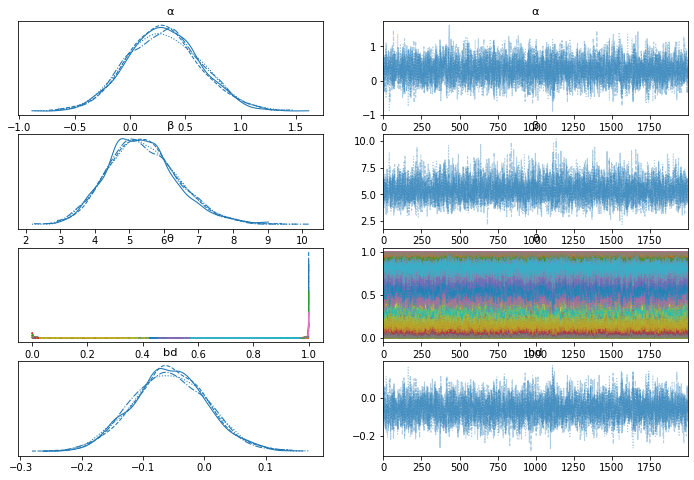

In [9]:
ax = az.plot_trace(trace_0)

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


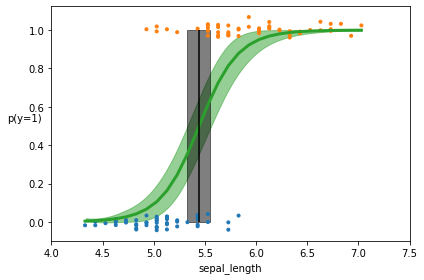

In [10]:
plt.figure()
# plot logistic curve
plt.plot(x_c[idx], theta[idx], color="C2", lw=3)
az.plot_hdi(x_c, trace_0["θ"], color="C2")

# plot decision boundary
plt.vlines(trace_0["bd"].mean(), 0, 1, color="k")
bd_hpd = az.hdi(trace_0["bd"])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color="k", alpha=0.5)

# plot jittered data
plt.scatter(x_c, np.random.normal(y_0, 0.02), marker=".", color=[f"C{x}" for x in y_0])


plt.xlabel(x_n)
plt.ylabel("p(y=1)", rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + xmean, 1))
# plt.xticks(x_c[idx], np.round(x_0[idx], 1))
plt.tight_layout()
# pml.savefig("logreg_iris_bayes_1d.pdf", dpi=300)

# plt.show()

In [27]:
t = trace_0[θ]

In [28]:
t.shape

(8000, 100)

(array([209795.,  98114.,  38415.,  18454.,  27990.,  38808.,  42303.,
         47430.,  60665., 218026.]),
 array([9.75492269e-06, 1.00008768e-01, 2.00007781e-01, 3.00006794e-01,
        4.00005807e-01, 5.00004821e-01, 6.00003834e-01, 7.00002847e-01,
        8.00001860e-01, 9.00000873e-01, 9.99999886e-01]),
 <BarContainer object of 10 artists>)

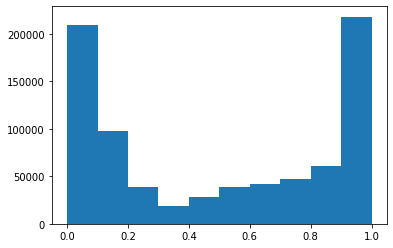

In [31]:
plt.hist(t.ravel()) # total histogram

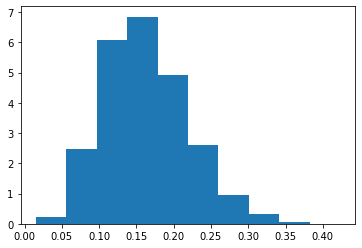

In [38]:
  # distribution of theta for 0-th observation
plt.hist(t[:,0], density=True);

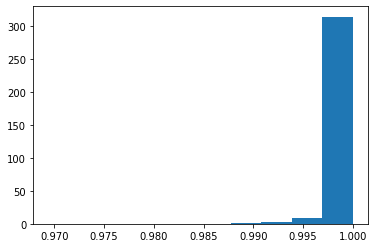

In [46]:
  # distribution of theta for 50-th observation
plt.hist(t[:,50], density=True);

5.9 1


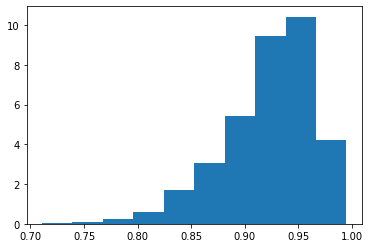

In [50]:
# distribution of theta for 50-th observation
print(x_0[70], y_0[70])
plt.hist(t[:, 70], density=True);